In [ ]:
##
## Homework Lab 3 (Week3)
##
##Author: Alejandro Mora

In [1]:
##Packages
%matplotlib inline
# import packages for text processing and machine learning in case needed
import pandas as pd  # DataFrame structure and operations
from pandas import DataFrame
import numpy as np  # arrays and numerical processing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  # 2D plotting
from scipy.stats import uniform
import statsmodels.api as sm  # logistic regression
import statsmodels.formula.api as smf  # R-like model specification
import patsy  # translate model specification into design matrices
import seaborn as sns  # PROVIDES TRELLIS AND SMALL MULTIPLE PLOTTING


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Gathering and Munging

In [2]:
##Read in the coaches data set
coaches = pd.read_html("Coaches9.html")

In [3]:
#Convert the list to a dataframe for analysis and find out structure of data
type(coaches)
#List to DataFrame, rename columns, and remove first uneccessary column
coachesdf = pd.DataFrame(np.concatenate(coaches))
coachesdf.columns = ['one','School', 'Conference', 'Coach',	'SchoolPay','TotalPay','Bonus','BonusPaid','AssistantPay','Buyout']
del coachesdf['one']
print(coachesdf.head())


                  School Conference  ... AssistantPay       Buyout
0              Air Force   Mt. West  ...           $0           --
1                  Akron        MAC  ...           $0     $688,500
2                Alabama        SEC  ...           $0  $33,600,000
3  Alabama at Birmingham      C-USA  ...           $0   $3,847,500
4      Appalachian State   Sun Belt  ...           $0   $2,160,417

[5 rows x 9 columns]


In [4]:
#Check NA Values or null values
print(coachesdf.isna().sum())
print(coachesdf.isnull().sum())

School          0
Conference      0
Coach           0
SchoolPay       0
TotalPay        0
Bonus           0
BonusPaid       0
AssistantPay    0
Buyout          0
dtype: int64
School          0
Conference      0
Coach           0
SchoolPay       0
TotalPay        0
Bonus           0
BonusPaid       0
AssistantPay    0
Buyout          0
dtype: int64


In [5]:
##Non-value items are labeled with "--", replace with "Nan" to view better
coachesdf = coachesdf.replace(to_replace="--", value= "NaN")

In [6]:
#View AssistantPay to see if the zero value is consistant
coachesdf["AssistantPay"]
#Assistant Pay seems to have no value to the data, Remove column
del coachesdf["AssistantPay"]
print(coachesdf.head())

##School Pay and Total Pay seem to be around the same value across the board.
##School Pay will be taken out and TotalPay will only be used
del coachesdf["SchoolPay"]

                  School Conference  ... BonusPaid       Buyout
0              Air Force   Mt. West  ...       NaN          NaN
1                  Akron        MAC  ...   $50,000     $688,500
2                Alabama        SEC  ...  $500,000  $33,600,000
3  Alabama at Birmingham      C-USA  ...  $165,471   $3,847,500
4      Appalachian State   Sun Belt  ...  $145,000   $2,160,417

[5 rows x 8 columns]


In [7]:
#View data types within columns
coachesdf.dtypes

School        object
Conference    object
Coach         object
TotalPay      object
Bonus         object
BonusPaid     object
Buyout        object
dtype: object

In [8]:
##Pay Values cannot be analyzed as strings so they must be converted to float values for evaluation
coachesdf['TotalPay'] = coachesdf['TotalPay'].replace({'\$':'',',': ''}, regex=True).astype(float)
coachesdf['Bonus'] = coachesdf['Bonus'].replace({'\$':'',',': ''}, regex=True).astype(float)
coachesdf['BonusPaid'] = coachesdf['BonusPaid'].replace({'\$':'',',': ''}, regex=True).astype(float)
coachesdf['Buyout'] = coachesdf['Buyout'].replace({'\$':'',',': ''}, regex=True).astype(float)
print(coachesdf['TotalPay'])

0       885000.0
1       412500.0
2      8307000.0
3       900000.0
4       712500.0
         ...    
124    3617500.0
125     805850.0
126     800000.0
127    3750000.0
128    1412000.0
Name: TotalPay, Length: 129, dtype: float64


In [9]:
#View rows that have the "NaN" value to determine if needed
sum(np.isin(coachesdf, ['NaN']))
print(coachesdf[coachesdf['TotalPay']=='NaN'].index.values)

[]


In [10]:
#Many schools in "bigger" conferences have a very large TotalPay for coaches or have no TotalPay recorded
#The schools reporting no pay can be taken out to help with data being skewed
print(coachesdf['TotalPay'])
coachesdf = coachesdf.drop(coachesdf.index[[12,16,91,99]])

0       885000.0
1       412500.0
2      8307000.0
3       900000.0
4       712500.0
         ...    
124    3617500.0
125     805850.0
126     800000.0
127    3750000.0
128    1412000.0
Name: TotalPay, Length: 129, dtype: float64


In [11]:
#Data needs more categorical variables to help with Pay determination
##Graduation Rates
##Source: https://www.ncaa.org/about/resources/research/shared-ncaa-research-data

GsrFsr = pd.read_csv("2018RES_File5-DISquadAggregationSA.csv")
print(GsrFsr)
#Check Variable names to only get Football stats
GsrFsr.columns

      SCL_UNITID                   SCL_NAME  ...  FED_RATE    GSR
0         100654     Alabama A&M University  ...      57.0   61.0
1         100654     Alabama A&M University  ...      47.0   62.0
2         100654     Alabama A&M University  ...      50.0   67.0
3         100654     Alabama A&M University  ...      29.0    NaN
4         100654     Alabama A&M University  ...      86.0   86.0
...          ...                        ...  ...       ...    ...
5398      486840  Kennesaw State University  ...      30.0   50.0
5399      486840  Kennesaw State University  ...      68.0   86.0
5400      486840  Kennesaw State University  ...       NaN  100.0
5401      486840  Kennesaw State University  ...      33.0   59.0
5402      486840  Kennesaw State University  ...      63.0   91.0

[5403 rows x 12 columns]


Index(['SCL_UNITID', 'SCL_NAME', 'SCL_DIVISION', 'SCL_SUBDIVISION',
       'SCL_CONFERENCE', 'DIV1_FB_CONFERENCE', 'SCL_HBCU', 'SCL_PRIVATE',
       'SPORT', 'SPONSORED', 'FED_RATE', 'GSR'],
      dtype='object')

In [12]:
#Delete uneccesary columns
del GsrFsr["SCL_UNITID"]
del GsrFsr["SCL_HBCU"]
del GsrFsr["SPONSORED"]
del GsrFsr["SCL_PRIVATE"]
del GsrFsr["SCL_CONFERENCE"]
del GsrFsr['SCL_SUBDIVISION']

In [13]:
#View Column Names remaining
GsrFsr.columns

Index(['SCL_NAME', 'SCL_DIVISION', 'DIV1_FB_CONFERENCE', 'SPORT', 'FED_RATE',
       'GSR'],
      dtype='object')

In [14]:
##Change column names for merging
GsrFsr.columns = ['School', 'Division', 'Conference', 'Sport', 'FGR', 'GSR']
print(GsrFsr.columns)

Index(['School', 'Division', 'Conference', 'Sport', 'FGR', 'GSR'], dtype='object')


In [15]:
#View data types of column variables
GsrFsr.dtypes

School         object
Division        int64
Conference     object
Sport          object
FGR           float64
GSR           float64
dtype: object

In [16]:
#Keep only columns containing Division 1 Schools and Football Program Rates
GsrFsr = GsrFsr.loc[GsrFsr['Division'] == 1]
GsrFsr = GsrFsr.loc[GsrFsr['Sport'] == 'MFB']

In [17]:
#Convert object School to strng and remove "University" and "University of" for data merging using regex
GsrFsr['School'] = GsrFsr['School'].replace({'University\sof\s':'','\sUniversity': ''}, regex=True).astype(str)
#Convert other schools like "Air Force", "UCLA", etc.
GsrFsr['School'] = GsrFsr['School'].replace({'California,\sLos\sAngeles':'UCLA'}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({'U.S.\sNaval\sAcademy':'Navy'}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({'U.S.\sAir\sForce\sAcademy':'Air Force'}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({',\sThe\sState\sNew\sJersey,\sNew Brunswick':''}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({'Bowling\sGreen\sState':'Bowling Green'}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({',\sFayetteville':''}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({',\sBerkeley':''}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({'University\sat\s':'',',\sthe\sState\sNew\sYork':''}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({'Louisiana\sat\sMonroe':'Louisiana-Monroe', 'Louisiana\sat\sLafayette':'Louisiana-Lafayette'}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({'\sat\sSan\sAntonio':'-San Antonio', '\sat\sEl\sPaso':'-El Paso'}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({',\sCollege\sStation':''}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({',\sBoulder':''}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({'California\sState,\sFresno':'Fresno State'}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({'Georgia\sInstitute\sof\sTechnology':'Georgia Tech'}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({',\sManoa':''}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({',\sBloomington':''}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({'\sUrbana-Champaign':''}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({'Louisiana\sState':'LSU'}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({',\sCollege\sPark':''}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({',\sAmherst':''}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({'Miami\s(Florida)':'Miami (Fla.)'}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({'Miami\s(Ohio)':'Miami (Ohio)'}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({'Middle\sTennessee\sState':'Middle Tennessee'}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({',\sTwin Cities':''}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({',\sColumbia':''}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({',\sLincoln':''}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({',\sReno':''}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({'The\sTulsa':'Tulsa'}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({'at\sAustin':''}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({', Knoxville':''}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({'-Madison':''}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({',\sLas Vegas':'-Las Vegas'}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({',\sChapel\sHill':''}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({'The\sOhio\sState':'Ohio State'}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({'South(Fla.)':'South Florida'}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({'Pennsylvania\sState':'Penn State'}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({'The\sNorth\sCarolina\sat\sCharlotte ':'Charlotte'}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({'The\sSouthern\sMississippi':'Southern Mississippi'}, regex=True).astype(str)
GsrFsr['School'] = GsrFsr['School'].replace({'Virginia\sPolytechnic\sInstitute\sand\sState':'Virginia Tech'}, regex=True).astype(str)


In [18]:
#View data to see if school names are changed correctly
print(GsrFsr['School'])

1                 Alabama A&M
18      Alabama at Birmingham
29              Alabama State
51                    Alabama
71                     Auburn
                ...          
5255            West Virginia
5301                Wisconsin
5325                  Wyoming
5358                 Stanford
5370                   Purdue
Name: School, Length: 252, dtype: object


In [19]:
##Merge Coaches Pay dataframe and GSR together
newcoaches = pd.merge(coachesdf, GsrFsr, on="School")
print(newcoaches.head())
newcoaches.columns

                  School Conference_x              Coach  ...  Sport   FGR   GSR
0              Air Force     Mt. West       Troy Calhoun  ...    MFB   NaN  77.0
1                  Akron          MAC       Terry Bowden  ...    MFB  61.0  72.0
2                Alabama          SEC         Nick Saban  ...    MFB  63.0  84.0
3  Alabama at Birmingham        C-USA         Bill Clark  ...    MFB  58.0  71.0
4      Appalachian State     Sun Belt  Scott Satterfield  ...    MFB  67.0  71.0

[5 rows x 12 columns]


Index(['School', 'Conference_x', 'Coach', 'TotalPay', 'Bonus', 'BonusPaid',
       'Buyout', 'Division', 'Conference_y', 'Sport', 'FGR', 'GSR'],
      dtype='object')

In [20]:
#Delete uneccessary columns from newcoaches
del newcoaches["Conference_y"]
del newcoaches["Sport"]

In [ ]:
###Stadium Size Data
##More Data to help with coach pay predictions
##source: https://github.com/gboeing/data-visualization/blob/master/ncaa-football-stadiums/data/stadiums-geocoded.csv

In [21]:
#Import Stadium Data
stadium = pd.read_csv("stadiums-geocoded.csv")
print(stadium.head())

            stadium             city state  ...  div   latitude  longitude
0  Michigan Stadium        Ann Arbor    MI  ...  fbs  42.265869 -83.748726
1    Beaver Stadium  University Park    PA  ...  fbs  40.812153 -77.856202
2      Ohio Stadium         Columbus    OH  ...  fbs  40.001686 -83.019728
3        Kyle Field  College Station    TX  ...  fbs  30.610098 -96.340729
4   Neyland Stadium        Knoxville    TN  ...  fbs  35.954734 -83.925333

[5 rows x 11 columns]


In [22]:
#View data types and columns
stadium.columns
stadium.dtypes

stadium        object
city           object
state          object
team           object
conference     object
capacity        int64
built           int64
expanded       object
div            object
latitude      float64
longitude     float64
dtype: object

In [23]:
#Since it didn't take some schools, more name changing will have to be done to the stadium data set
stadium['team'] = stadium['team'].replace({'FIU':'Florida International'}, regex=True).astype(str)
stadium['team'] = stadium['team'].replace({'UTEP':'Texas-El Paso'}, regex=True).astype(str)
stadium['team'] = stadium['team'].replace({'UTSA':'Texas-San Antonio'}, regex=True).astype(str)

In [24]:
#Delete uneccessary columns(capacity is only needed with school)
stadium2 = DataFrame(data = stadium, columns=["team","capacity"])
stadium2.dtypes

#Change "team" to "School"
stadium2 = stadium2.rename(columns = {"team":"School"})
print(stadium2)
print(stadium2["School"])

                      School  capacity
0                   Michigan    107601
1                 Penn State    106572
2                 Ohio State    104944
3                  Texas A&M    102733
4                  Tennessee    102455
..                       ...       ...
248  Saint Francis Red Flash      3500
249          Wagner Seahawks      3300
250  Robert Morris Colonials      3000
251         Georgetown Hoyas      2500
252           Duquesne Dukes      2200

[253 rows x 2 columns]
0                     Michigan
1                   Penn State
2                   Ohio State
3                    Texas A&M
4                    Tennessee
                ...           
248    Saint Francis Red Flash
249            Wagner Seahawks
250    Robert Morris Colonials
251           Georgetown Hoyas
252             Duquesne Dukes
Name: School, Length: 253, dtype: object


In [25]:
#Merge newcoaches Data Frame and stadium
newcoaches = pd.merge(newcoaches, stadium2, on="School")
print(newcoaches.head())
newcoaches.columns

              School Conference_x              Coach  ...   FGR   GSR  capacity
0          Air Force     Mt. West       Troy Calhoun  ...   NaN  77.0     46692
1              Akron          MAC       Terry Bowden  ...  61.0  72.0     30000
2            Alabama          SEC         Nick Saban  ...  63.0  84.0    101821
3  Appalachian State     Sun Belt  Scott Satterfield  ...  67.0  71.0     24050
4            Arizona       Pac-12       Kevin Sumlin  ...  63.0  76.0     51811

[5 rows x 11 columns]


Index(['School', 'Conference_x', 'Coach', 'TotalPay', 'Bonus', 'BonusPaid',
       'Buyout', 'Division', 'FGR', 'GSR', 'capacity'],
      dtype='object')

In [26]:
#Remove another column and rename some columns
del newcoaches["Division"]
newcoaches = newcoaches.rename(columns= {"capacity":"Stadium_Capacity"})
newcoaches = newcoaches.rename(columns= {"Conference_x":"Conference"})
print(newcoaches.head())
newcoaches.dtypes

              School Conference  ...   GSR  Stadium_Capacity
0          Air Force   Mt. West  ...  77.0             46692
1              Akron        MAC  ...  72.0             30000
2            Alabama        SEC  ...  84.0            101821
3  Appalachian State   Sun Belt  ...  71.0             24050
4            Arizona     Pac-12  ...  76.0             51811

[5 rows x 10 columns]


School               object
Conference           object
Coach                object
TotalPay            float64
Bonus               float64
BonusPaid           float64
Buyout              float64
FGR                 float64
GSR                 float64
Stadium_Capacity      int64
dtype: object

In [ ]:
###Another data frame consisting variables for analysis
##Record Data
###Source: https://www.sports-reference.com/cfb/years/2018-ratings.html

In [27]:
#Import record data
records = pd.read_html("sportsref_download (2).xls")
recordsdf = pd.DataFrame(np.concatenate(records))
recordsdf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1,Clemson,ACC (Atlantic),1,15,0,9.41,17.04,26.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Alabama,SEC (West),2,14,1,12.19,13.1,25.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Georgia,SEC (East),7,11,3,9.53,11.17,20.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Oklahoma,Big 12,4,12,2,21.41,-3.35,18.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Ohio State,Big Ten (East),3,13,1,15.24,2.5,17.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
#Delete uneccessary columns and rename variables
#Columns have to be renamed before removal, number columns will be deleted
recordsdf.columns = ['Rank', 'School', 'Conference', 'APRank', 'Wins', 'Loses', 'OSRS', 'DSRS', 'SRS', '1','2','3','4','5','6','7','8']
recordsdf = recordsdf.drop(columns=['1','2','3','4','5','6','7','8'])

In [29]:
#Convert records school names to match with other DFs
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)
print(recordsdf)

    Rank                  School       Conference APRank Wins Loses   OSRS  \
0      1                 Clemson   ACC (Atlantic)      1   15     0   9.41   
1      2                 Alabama       SEC (West)      2   14     1  12.19   
2      3                 Georgia       SEC (East)      7   11     3   9.53   
3      4                Oklahoma           Big 12      4   12     2  21.41   
4      5              Ohio State   Big Ten (East)      3   13     1  15.24   
5      6              Notre Dame              Ind      5   12     1   5.57   
6      7                Michigan   Big Ten (East)     14   10     3   5.92   
7      8                     LSU       SEC (West)      6   10     3    8.4   
8      9                     UCF  American (East)     11   12     1  10.24   
9     10                 Florida       SEC (East)      7   10     3   5.91   
10    11               Texas A&M       SEC (West)     16    9     4  10.78   
11    12       Mississippi State       SEC (West)    NaN    8   

In [30]:
#Rename schools using regex
recordsdf['School'] = recordsdf['School'].replace({'UTEP':'Texas-El Paso','UTSA': 'Texas-San Antonio'}, regex=True).astype(str)

In [31]:
##Merge DataFrames together for analysis
newcoaches = pd.merge(newcoaches, recordsdf, on="School")
print(newcoaches)

                    School Conference_x               Coach   TotalPay  \
0                Air Force     Mt. West        Troy Calhoun   885000.0   
1                    Akron          MAC        Terry Bowden   412500.0   
2                  Alabama          SEC          Nick Saban  8307000.0   
3        Appalachian State     Sun Belt   Scott Satterfield   712500.0   
4                  Arizona       Pac-12        Kevin Sumlin  2000000.0   
5            Arizona State       Pac-12        Herm Edwards  2000000.0   
6                 Arkansas          SEC         Chad Morris  3500000.0   
7           Arkansas State     Sun Belt      Blake Anderson   825000.0   
8                   Auburn          SEC         Gus Malzahn  6705656.0   
9               Ball State          MAC            Mike Neu   435689.0   
10             Boise State     Mt. West        Bryan Harsin  1650010.0   
11          Boston College          ACC       Steve Addazio  2514859.0   
12                 Buffalo          MA

In [32]:
##Delete uneccessary columns again and rename columns for easy analysis
newcoaches.columns
newcoaches = newcoaches.drop(columns=['Conference_y'])
newcoaches.columns = ['School','Conference','Coach','TotalPay','Bonus','BonusPaid','Buyout','FGR','GSR','Stadium_Capacity','Rank','APRank','Wins','Loses','OSRS','DSRS','SRS']
##Convert object types of Rank, Wins, Loses, OSRS, DSRS, and SRS to float
newcoaches['Rank'] = newcoaches['Rank'].astype(float)
newcoaches['APRank'] = newcoaches['APRank'].astype(float)
newcoaches['Wins'] = newcoaches['Wins'].astype(float)
newcoaches['Loses'] = newcoaches['Loses'].astype(float)
newcoaches['OSRS'] = newcoaches['OSRS'].astype(float)
newcoaches['DSRS'] = newcoaches['DSRS'].astype(float)
newcoaches['SRS'] = newcoaches['SRS'].astype(float)

## View Data at hand and view descriptive statistics

Text(0.5, 1.0, 'Total Pay Medians based on Conference(In Millions)')

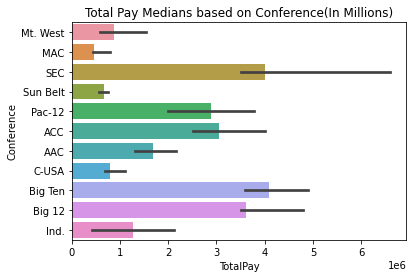

In [33]:
#Create plots of school based on conference
#Conference TotalPay is based on median and shows error as well
from numpy import median
pay_plot = sns.barplot(data = newcoaches, y = 'Conference', x= 'TotalPay', orient="h", estimator= median)
plt.title('Total Pay Medians based on Conference(In Millions)')

In [34]:
##Descriptive Statistics of TotalPay
##
##
print("Mean Total Pay of Coaches:")
print(round(np.mean(newcoaches['TotalPay']), 2))
print("\nMedian Total Pay of Coaches:")
print(round(np.median(newcoaches['TotalPay']), 2))
print("\nMinimum Total Pay of Coaches:")
print(round(np.min(newcoaches['TotalPay']), 2))
print("\nMaximum Total Pay of Coaches:")
print(round(np.max(newcoaches['TotalPay']), 2))

Mean Total Pay of Coaches:
2570260.33

Median Total Pay of Coaches:
2129638.0

Minimum Total Pay of Coaches:
390000.0

Maximum Total Pay of Coaches:
8307000.0


In [35]:
#There is a big difference in some conference pay,
#Count of schools in each conference to see if there are any discrepancies
ConfCount = newcoaches.groupby(by='Conference', as_index=False).agg({'School': pd.Series.nunique})
print(ConfCount)

   Conference  School
0         AAC       8
1         ACC      11
2      Big 12       7
3     Big Ten      14
4       C-USA       9
5        Ind.       2
6         MAC       9
7    Mt. West      11
8      Pac-12      11
9         SEC      13
10   Sun Belt       8


In [36]:
#Not many independent schools so they can be ommitted from analysis to get rid of skewed results
print(newcoaches[newcoaches['Conference']=='Ind.'].index.values)
newcoaches = newcoaches.drop(newcoaches.index[[58,62]])
newcoaches = newcoaches.reset_index(drop=True)

[58 62]


  Conference  School
0        AAC       8
1        ACC      11
2     Big 12       7
3    Big Ten      14
4      C-USA       9
5        MAC       9
6   Mt. West      11
7     Pac-12      11
8        SEC      13
9   Sun Belt       8


Text(0.5, 1.0, 'Number of Schools in each Conference Recorded')

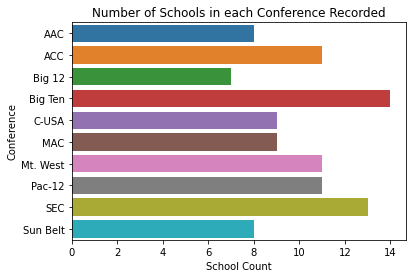

In [37]:
#Plot Conference Counts
ConfCount = newcoaches.groupby(by='Conference', as_index=False).agg({'School': pd.Series.nunique})
print(ConfCount)
ConfCount.columns = ['Conference', "School Count"]
sns.barplot(data=ConfCount, y ='Conference', x = 'School Count', orient='h')
plt.title('Number of Schools in each Conference Recorded')

Text(0, 0.5, 'Total Pay')

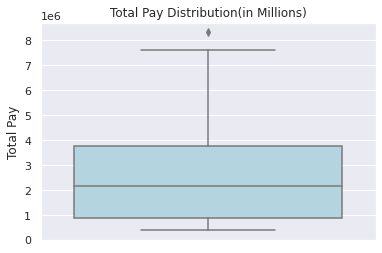

In [38]:
#Boxplot showing distribution of Total Pay amoungst coaches
sns.set(style="darkgrid")
Payboxplot = sns.boxplot(data = newcoaches, y = 'TotalPay', color= "lightblue")
plt.title('Total Pay Distribution(in Millions)')
plt.ylabel('Total Pay')

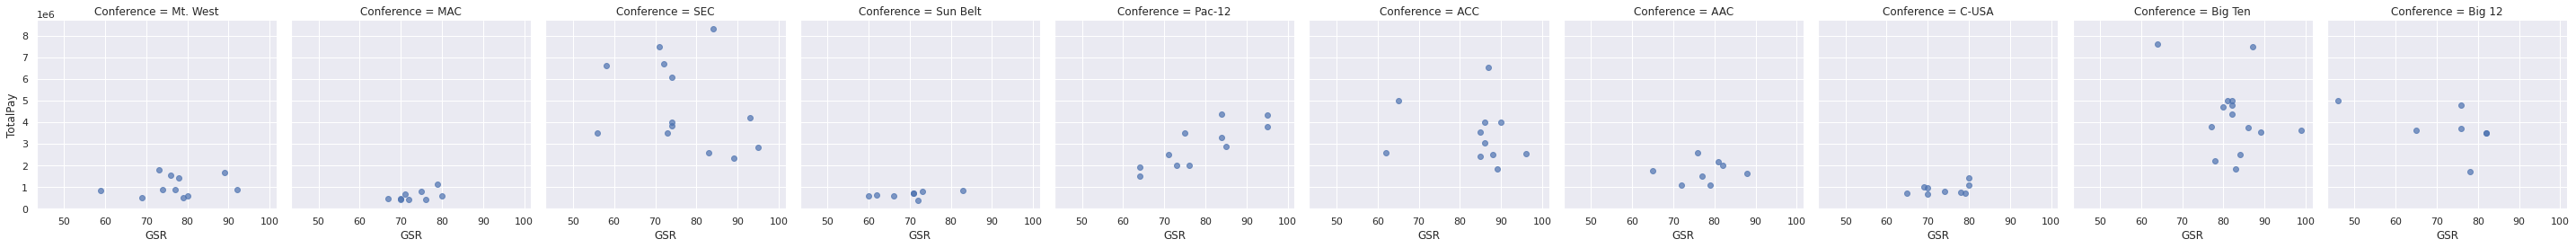

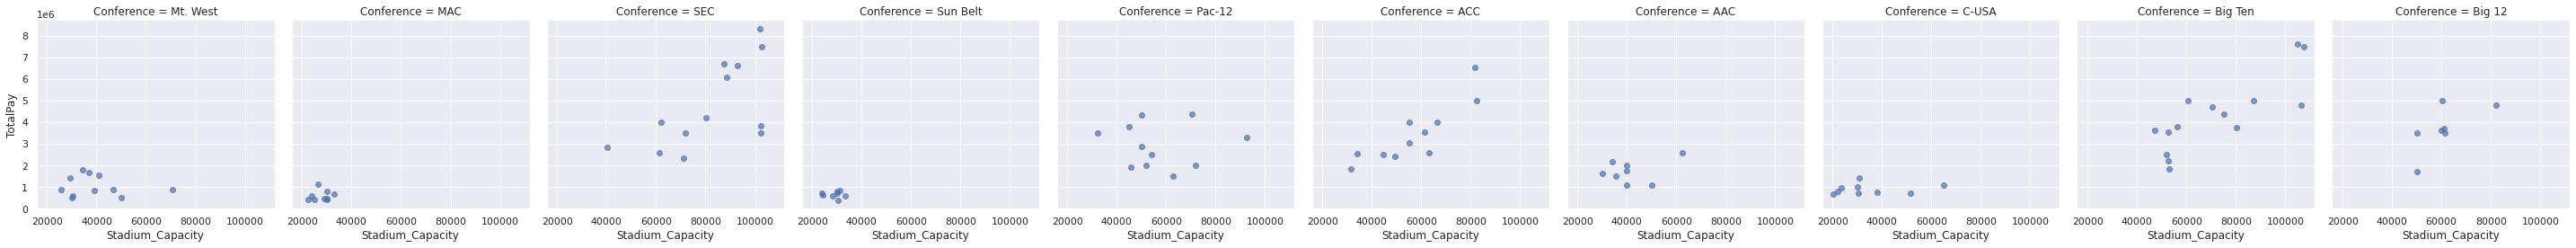

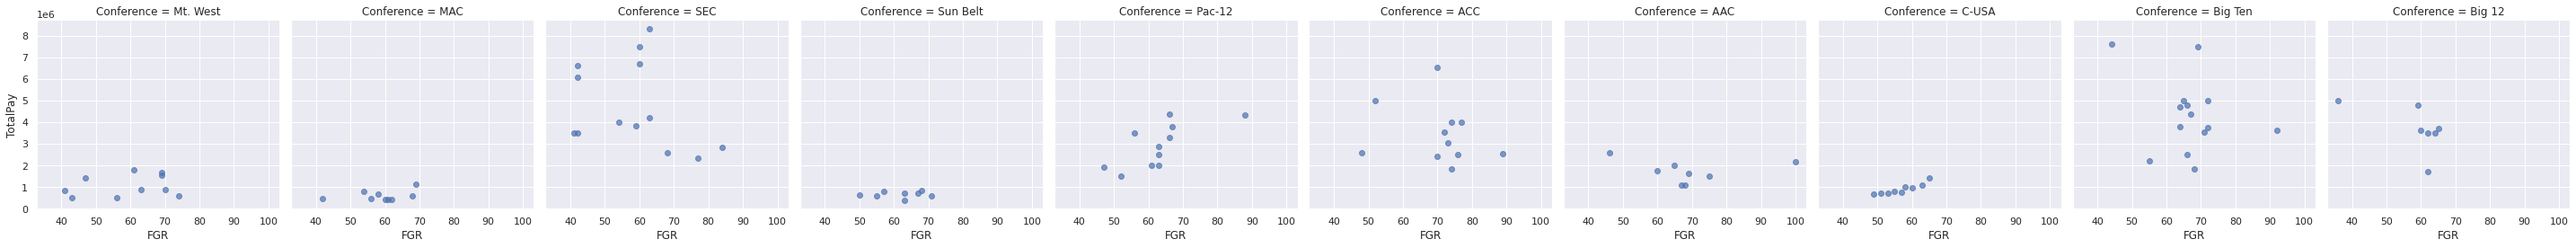

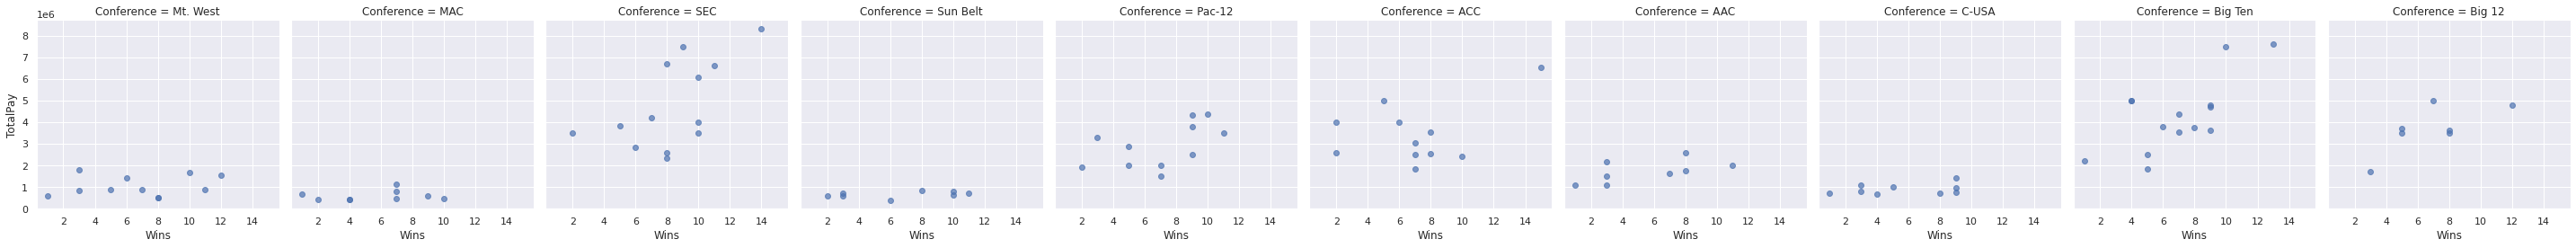

In [39]:
#Scatterplots to see correlation of variables on TotalPay

sns.set(style="darkgrid")
#Total Pay and Graduation Success Rate by conference
Splot1 = sns.FacetGrid(newcoaches, col="Conference", height= 4)
Splot1.map(plt.scatter, "GSR", "TotalPay", alpha=.7)
plt.show()
#Total Pay and Stadium Capacity by conference
Splot2 = sns.FacetGrid(newcoaches, col="Conference", height= 4)
Splot2.map(plt.scatter, "Stadium_Capacity", "TotalPay", alpha=.7)
plt.show()
#Total Pay and Federal Graduation Rate by conference
Splot2 = sns.FacetGrid(newcoaches, col="Conference", height= 4)
Splot2.map(plt.scatter, "FGR", "TotalPay", alpha=.7)
plt.show()
#Total Pay and Wins by conference
Splot2 = sns.FacetGrid(newcoaches, col="Conference", height= 4)
Splot2.map(plt.scatter, "Wins", "TotalPay", alpha=.7)
plt.show()

In [ ]:
#Histogram of stadium capacitys within conferences

Text(0.5, 1.0, 'Correlation of Total Pay with other Variables')

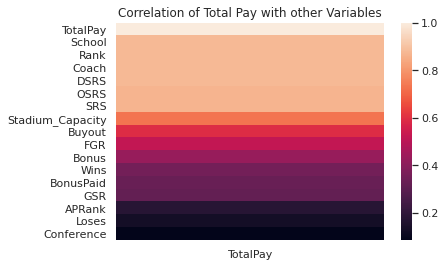

In [40]:
#Correlation Map between variables
#Factorize the variables in the columns before sorting the variables from lowest to highest correlation
correlation = newcoaches.apply(lambda x: pd.factorize(x)[0]).corr()[['TotalPay']].sort_values(by='TotalPay', ascending=False)
sns.heatmap(correlation)
plt.title('Correlation of Total Pay with other Variables')

## Linear Regression Models


In [41]:
###Create training and testing data for model validation
###
##30/70 Split
#Random Seed
np.random.seed(1000)
newcoaches['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(newcoaches))
coaches_train = newcoaches[newcoaches['runiform'] >= 0.33]
coaches_test = newcoaches[newcoaches['runiform'] < 0.33]

#Train set
print(coaches_train.head())
#Test Set
print(coaches_test.head())

              School Conference              Coach   TotalPay      Bonus  \
0          Air Force   Mt. West       Troy Calhoun   885000.0   247000.0   
2            Alabama        SEC         Nick Saban  8307000.0  1100000.0   
3  Appalachian State   Sun Belt  Scott Satterfield   712500.0   295000.0   
4            Arizona     Pac-12       Kevin Sumlin  2000000.0  2025000.0   
7     Arkansas State   Sun Belt     Blake Anderson   825000.0   185000.0   

   BonusPaid      Buyout   FGR   GSR  Stadium_Capacity  Rank  APRank  Wins  \
0        NaN         NaN   NaN  77.0             46692  84.0     NaN   5.0   
2   500000.0  33600000.0  63.0  84.0            101821   2.0     2.0  14.0   
3   145000.0   2160417.0  67.0  71.0             24050  25.0     NaN  11.0   
4        NaN  10000000.0  63.0  76.0             51811  76.0     NaN   5.0   
7    25000.0    300000.0  68.0  83.0             30964  69.0     NaN   8.0   

   Loses   OSRS   DSRS    SRS  runiform  
0    7.0   0.47  -2.19  -1.72  0

###Model 1

In [46]:
##All Variables
model1 = str('TotalPay ~ Stadium_Capacity + Conference + Wins + GSR + FGR + Loses + APRank + Rank + SRS')

In [47]:
##Testing Model 1
##
##
## Model 1 on Training and Testing(fitted)
train_model = smf.ols(model1, data = coaches_train).fit()
print(train_model.summary())

# training set predictions
coaches_train['predict_salary1'] = train_model.fittedvalues

# test set predictions
coaches_test['predict_salary1'] = train_model.predict(coaches_test)

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     1.955
Date:                Sat, 30 Jan 2021   Prob (F-statistic):              0.319
Time:                        22:58:36   Log-Likelihood:                -252.90
No. Observations:                  17   AIC:                             533.8
Df Residuals:                       3   BIC:                             545.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -3.96

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


###Model 2

In [48]:
#Model 2( No Bonus Variables, No APRank, No Loses, No OSRS, No DSRS, No FGR)
model2 = str('TotalPay ~ Conference + Stadium_Capacity + Wins + GSR + SRS + Rank')

In [49]:
##Testing Model 2
##
##
## Model 2 on Training and Testing(fitted)
train_model2 = smf.ols(model2, data = coaches_train).fit()
print(train_model2.summary())

# training set predictions from fit 
coaches_train['predict_salary'] = train_model2.fittedvalues

# test set predictions from the model fit to the training set
coaches_test['predict_salary'] = train_model2.predict(coaches_test)

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     23.62
Date:                Sat, 30 Jan 2021   Prob (F-statistic):           1.84e-17
Time:                        22:58:44   Log-Likelihood:                -988.77
No. Observations:                  66   AIC:                             2008.
Df Residuals:                      51   BIC:                             2040.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               8.97

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


##Model3

In [58]:
#Model 3 (No GSR, No Wins compared to model 2)
model3 = str('TotalPay ~ Conference + Stadium_Capacity + SRS + Rank')

In [59]:
##Testing Model 3
##
##
## Model 2 on Training and Testing(fitted)
train_model3 = smf.ols(model3, data = coaches_train).fit()
print(train_model3.summary())

# training set predictions from fit 
coaches_train['predict_salary'] = train_model3.fittedvalues

# test set predictions from the model fit to the training set
coaches_test['predict_salary'] = train_model3.predict(coaches_test)

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     27.81
Date:                Sat, 30 Jan 2021   Prob (F-statistic):           1.22e-18
Time:                        23:28:17   Log-Likelihood:                -989.60
No. Observations:                  66   AIC:                             2005.
Df Residuals:                      53   BIC:                             2034.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -4.9

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [52]:
#Create Predictions on all data based on third model
Model_fit2 = smf.ols(model3, data = newcoaches).fit()
print(Model_fit2.summary())

# training set predictions
newcoaches['predict_salary'] = Model_fit2.fittedvalues
# test set predictions
newcoaches['predict_salary'] = Model_fit2.predict(newcoaches)

print('Predicted Pay for Syracuse Coach:', round(newcoaches.loc[newcoaches['School'] == 'Syracuse', 'predict_salary'].iloc[0]))

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     32.94
Date:                Sat, 30 Jan 2021   Prob (F-statistic):           2.04e-27
Time:                        22:58:55   Log-Likelihood:                -1518.5
No. Observations:                 101   AIC:                             3063.
Df Residuals:                      88   BIC:                             3097.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -8.2

In [53]:
#Change Syracuse to be in the Big10
##
##
newcoaches.loc[(newcoaches.School == 'Syracuse'), 'Conference']='Big Ten'

In [54]:
#Create Predictions on all data based on second model in Big 10
Model_fit3 = smf.ols(model3, data = newcoaches).fit()
print(Model_fit3.summary())

# training set predictions
newcoaches['predict_salary1'] = Model_fit3.fittedvalues
# test set predictions
newcoaches['predict_salary1'] = Model_fit3.predict(newcoaches)

                            OLS Regression Results                            
Dep. Variable:               TotalPay   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     32.70
Date:                Sat, 30 Jan 2021   Prob (F-statistic):           2.61e-27
Time:                        22:59:00   Log-Likelihood:                -1518.8
No. Observations:                 101   AIC:                             3064.
Df Residuals:                      88   BIC:                             3098.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -7.4

In [55]:
print('Predicted Pay for Syracuse Coach if in Big 10:', round(newcoaches.loc[newcoaches['School'] == 'Syracuse', 'predict_salary1'].iloc[0]))

Predicted Pay for Syracuse Coach if in Big 10: 3618445
